# JavaPresse: Critical Review Filtering

Last Updated: Apr 11, 2020

* Scraping 5000 Amazon reviews of JavaPresse Coffee Manual Grinder 
* Grouping data into negative (1 and 2 star rated) and non-negative reviews (3,4 and 5 star rated)
* Training various classifiers and performing a grid search with cross validation

***


Parts of this project have been inspired by Abhishek Thakur's work on approaching NLP problems which can be accessed [here](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) and Dipanjan Sarkar's notes on text analytics which can be located [here](https://github.com/dipanjanS/text-analytics-with-python).

I would also like to thank the IBM teaching staff for providing the required skills and tools to complete this project as part of the Advanced Data Science Specialization on Coursera.

### Importing libraries

In [171]:
# library to handle files, expressions and time
import os
import time
import re

# importing iterators
import itertools

# library to display progress bars
from tqdm.notebook import tqdm

# library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# libraries to handle dataframes and array operations
import pandas as pd
import numpy as np

# library for visualization
import matplotlib.pyplot as plt

# library for language processing
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# importing preprocessing tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight

# importing standard machine learning classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

# importing gradient boosting classifier
from xgboost import XGBClassifier

# importing tools for building a neural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import CSVLogger
from keras_tqdm import TQDMNotebookCallback

# importing machine learning wrapper for neural network
from keras.wrappers.scikit_learn import KerasClassifier

# importing evaulation metrics
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# importing tools for pipeline creation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Data Exploration & Cleaning

In [172]:
# defining path to source data
str_file_path=r'...'
df=pd.read_csv(str_file_path)

In [173]:
# viewing first five rows
df.head()

,stars,comment
0,4.0 out of 5 stars,\n\n\n\n\n\n\n\n \n \n Very slow. My ket...
1,1.0 out of 5 stars,\n\n\n\n\n\n\n\n \n \n The design seems f...
2,5.0 out of 5 stars,\n\n\n\n\n\n\n\n \n \n Hey there Folks! S...
3,5.0 out of 5 stars,\n\n\n\n\n\n\n\n \n \n I've always HEARD ...
4,5.0 out of 5 stars,\n\n\n\n\n\n\n\n \n \n I love this item. ...


In [174]:
# defining a function to view class distributions
def class_dist(cl_lbl):
    cl_lbl.value_counts().plot(kind='bar')
    plt.xlabel("Labels", labelpad=14, fontsize=12)
    plt.ylabel("Count of Labels", labelpad=14, fontsize=12)
    plt.title("Class Distribution", y=1.02, fontsize=16)

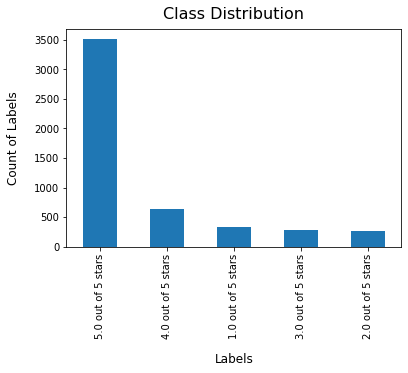

In [175]:
# viewing initial distributions
class_dist(df['stars'])

In [176]:
# regrouping data to create a two class classification problem
df['stars'] = LabelEncoder().fit_transform((df['stars']))
df = df.replace({'stars': {1: 0, 2:3, 4: 3}}).replace({'stars': {3:1}})

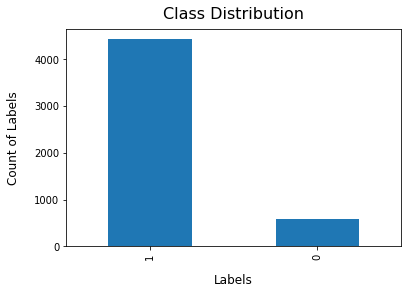

In [177]:
# viewing updated class distrubutions
class_dist(df['stars'])

In [178]:
# function to extract alphabetic characters
def clean_first(comment, keep_apostrophes=False):
    comment = comment.strip()
    PATTERN = r'[^a-zA-Z]'
    filtered_comment = re.sub(PATTERN, r' ', comment)
    return filtered_comment

In [179]:
# defining function for tokenization of text
def tok_txt(text, w_stem=False):
    tokens = nltk.word_tokenize(text.lower())
    if w_stem:
        tokens = [stem_txt(token.strip()) for token in tokens]
    else:
        tokens = [(token.strip()) for token in tokens]
    return tokens

In [180]:
# defining a stemming function if it might be needed later on
def stem_txt(token):
    return PorterStemmer.stem(token)

In [181]:
# defining a function to remove stopwords
def remove_stopwords(text):
    tokens = tok_txt(text)
    filtered_tokens = [token for token in tokens if token not in stop_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [182]:
# defining a master function to call functions that tokenize text and remove stopwords 
def norm_txt(corpus, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = remove_stopwords(text)
        normalized_corpus.append(text)
    return normalized_corpus

In [183]:
# removing empty lines and blank spaces
df['comment_p'] = df['comment'].replace('\n','', regex=True).replace('  ',' ', regex=True).str.strip()

stop_list = nltk.corpus.stopwords.words('english')

# calling functions to clean data
temp_list = []
for i, x in tqdm(df.iterrows()):
    temp_elem = [x for x in norm_txt(tok_txt(clean_first(x['comment']), w_stem=False)) if x!='']
    temp_list.append(' '.join(temp_elem))
    
df['comment_p'] = temp_list

### Defining Train & Test Features

In [184]:
# definiing training and testing features
X = df['comment_p']
y= df['stars']

# splitting into training and testing sets
o_X_train, o_X_test, o_y_train, o_y_test = train_test_split(X,y, test_size=0.2, 
                                                            stratify=y, random_state=10)

In [185]:
# defining a function to convert text to numeric values
def w2numbers(train_data, test_data):
    t_vectorizer=TfidfVectorizer(min_df=3,  max_features=None, 
                                 strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                                 ngram_range=(1, 3), use_idf=1,smooth_idf=1,
                                 sublinear_tf=1, stop_words = stop_list)

    tfidf = t_vectorizer.fit(list(train_data) + list(test_data))

    train_data = tfidf.transform(train_data).todense()
    test_data =  tfidf.transform(test_data).todense()

    return train_data, test_data

In [186]:
# defining a function for singular value decomposition
def svd_baseline(train_d, test_d, svd_n):
    svd = TruncatedSVD(svd_n)
    svd.fit(train_d)
    train_d = svd.transform(train_d)
    test_d = svd.transform(test_d)
    
    return train_d, test_d 

In [187]:
# loading Glove (42B, 300d) embeddings; 
# you can markdown this cell and the one below it if you are running the notebook on a local system and don't have the embeddings file
embeddings_index = {}
glove = r'...'
f = open(glove, encoding="utf-8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1917494 word vectors.


In [188]:
# defining a function to call embeddings
def sent2vec(s, s_l):
    words = word_tokenize(str(s))
    words = [w for w in words if not w in s_l]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [189]:
# defining a function to classify inputs using various machine learning algorithms
def ml_clf_li_algo(xtr, xte, ytr, yte):
    
    # computing class weights
    pop_weights = dict(enumerate(compute_class_weight('balanced', np.unique(ytr), 
                                                     ytr)))
    
    def algo_dict_weights(wei):
        
        dict_estimator = {'Naive_Bayes_Baseline': MultinomialNB(), 
                  'Logistic_Regression_Baseline': LogisticRegression(class_weight = wei), 
                  'Linear_SVC_Baseline': LinearSVC(class_weight = wei),
                  'SVC_Baseline': SVC(class_weight = wei),  
                  'Random_Forest_Baseline': RandomForestClassifier(class_weight = wei), 
                  'Gradient_Boosting_Baseline': XGBClassifier(class_weight = wei)}
        
        return dict_estimator
    
    clf_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    time_list = []
    conf_list = []
    
    ml_out_dict = algo_dict_weights(pop_weights)
    
    # fitting and evaluation
    for d_key in tqdm(ml_out_dict.keys()): 
        clf = ml_out_dict.get(d_key)
        if d_key=='Naive_Bayes_Baseline':
            scale=MinMaxScaler()
        else:
            scale=StandardScaler()
        scale.fit(xtr)
        xtr = scale.transform(xtr)
        xte = scale.transform(xte)
        t0 = time.time()
        clf.fit(xtr, ytr)
        clf_list.append(d_key)
        f1_list.append(round(f1_filter(yte, clf.predict(xte)),3))
        recall_list.append(round(recall_filter(yte, clf.predict(xte)),3))
        precision_list.append(round(precision_filter(yte, clf.predict(xte)),3))
        t1 = time.time()
        time_list.append(round(t1-t0,3))
        
        conf_list.append(confusion_matrix(yte, clf.predict(xte))) 
    
        
    metrics_df = pd.DataFrame.from_dict({'Classifier': clf_list, 
                                         'F1-Score': f1_list,
                                         'Recall': recall_list,
                                         'Precision': precision_list,
                                         'Evalutation Time': time_list})
    
    print("Evaluation Metrics for Critical Reviews:", "\n")
    print(metrics_df)

In [190]:
# defining a function for classification using neural networks
def dl_clf_ff_algo(xtr, xte, ytr, yte):
    
    scale=StandardScaler()
    scale.fit(xtr)
    xtr = scale.transform(xtr)
    xte = scale.transform(xte)
    
    # computing class weights
    pop_weights = dict(enumerate(compute_class_weight('balanced', np.unique(ytr), 
                                                     ytr)))
    
    def FF_NN_ne_def():
        model = Sequential()

        model.add(Dense(32, input_dim=xtr.shape[1], activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(2))
        model.add(Activation('softmax'))
    
        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
        
        return model
    
    # wrapping the neural network model using sklearn
    model_build = KerasClassifier(build_fn=FF_NN_ne_def, epochs=200, 
                                  batch_size=128, validation_split = 0.2, 
                                  verbose=0, class_weight=pop_weights)
    
    model_build_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    time_list = []
    
    # removing training history log file if already present
    try:
        os.remove('log.csv')
    except OSError:
        pass
    
    # creating a logger to store loss histories
    csv_logger = CSVLogger('log.csv', append=True, separator=',')
    
    t0 = time.time()
    model_build.fit(xtr, ytr, callbacks=[TQDMNotebookCallback(), csv_logger])
    model_build_list.append("Feedforward_Network_Baseline")
    f1_list.append(round(f1_filter(yte, model_build.predict(xte)),3))
    recall_list.append(round(recall_filter(yte, model_build.predict(xte)),3))
    precision_list.append(round(precision_filter(yte, model_build.predict(xte)),3))
    t1 = time.time()
    time_list.append(round(t1-t0,3))
    
    # plotting evaluations
    df=pd.read_csv('log.csv', header=0)
    plt.plot(df.iloc[:, :1], df.iloc[:, 1:2], '-r', label='tr_loss') 
    plt.plot(df.iloc[:, :1], df.iloc[:, 2:], '-g', label='val_loss') 
    plt.xlabel("Epoch Number", labelpad=14, fontsize=12)
    plt.ylabel("Loss", labelpad=14, fontsize=12)
    plt.title("Feedforward Network: Evaluation", y=1.02, fontsize=16)
    plt.legend(loc="upper left")
    plt.show()
    print("-"*126,"\n\n\n\n") 
    
    metrics_df = pd.DataFrame.from_dict({'Classifier': model_build_list, 
                                         'F1-Score': f1_list,
                                         'Recall': recall_list,
                                         'Precision': precision_list,
                                         'Evalutation Time': time_list})
    
    print("Evaluation Metrics for Critical Reviews:", "\n")
    print(metrics_df)

In [191]:
# creating custom f1 scorer for minority class (critical reviews)
def f1_filter(y_true, y_pred, pos_label=0):
            return f1_score(y_true, y_pred, pos_label=0)

In [192]:
# creating custom recall scorer for minority class (critical reviews)
def recall_filter(y_true, y_pred, pos_label=0):
            return recall_score(y_true, y_pred, pos_label=0)

In [193]:
# creating custom precision scorer for minority class (critical reviews)
def precision_filter(y_true, y_pred, pos_label=0):
            return precision_score(y_true, y_pred, pos_label=0)

### Machine Learning

#### Undersampling, TfIdf

In [194]:
# Dataframes for undersamping
o_Train_df = pd.DataFrame.from_dict({'comment_p': o_X_train, 
                                     'stars': o_y_train}).sample(frac=1, random_state=10)

us_df =  pd.concat([o_Train_df.loc[df['stars'] == 1][: o_Train_df.loc[df['stars'] == 0].shape[0]], 
                            o_Train_df.loc[df['stars'] == 0]])

In [195]:
# preprocessing
X_train, X_test = w2numbers(us_df['comment_p'], o_X_test)
X_train, X_test = svd_baseline(X_train, X_test, 200)
y_train = us_df['stars']

In [196]:
# training and evaluation
ml_clf_li_algo(X_train, X_test, y_train, o_y_test)


Evaluation Metrics for Critical Reviews: 

                     Classifier  F1-Score  Recall  Precision  Evalutation Time
0          Naive_Bayes_Baseline     0.583   0.897      0.432             0.024
1  Logistic_Regression_Baseline     0.605   0.879      0.462             0.064
2           Linear_SVC_Baseline     0.586   0.853      0.446             0.164
3                  SVC_Baseline     0.650   0.767      0.563             0.856
4        Random_Forest_Baseline     0.556   0.836      0.416             0.672
5    Gradient_Boosting_Baseline     0.566   0.888      0.415             0.636


### Deep Learning

#### Undersampling, TfIdf

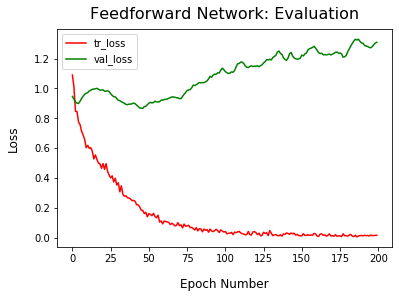

------------------------------------------------------------------------------------------------------------------------------ 




Evaluation Metrics for Critical Reviews: 

                     Classifier  F1-Score  Recall  Precision  Evalutation Time
0  Feedforward_Network_Baseline     0.601    0.81      0.477            22.308


In [197]:
# training and evaulation
dl_clf_ff_algo(X_train, X_test, y_train, o_y_test)

### Machine Learning

#### Class Balancing, TfIdf

In [198]:
# preprocessing
X_train, X_test = w2numbers(o_X_train, o_X_test)
X_train, X_test = svd_baseline(X_train, X_test, 200)
y_train = o_y_train

In [199]:
# training and evaulation
ml_clf_li_algo(X_train, X_test, y_train, o_y_test)


Evaluation Metrics for Critical Reviews: 

                     Classifier  F1-Score  Recall  Precision  Evalutation Time
0          Naive_Bayes_Baseline     0.000   0.000      0.000             0.244
1  Logistic_Regression_Baseline     0.630   0.845      0.503             0.080
2           Linear_SVC_Baseline     0.644   0.810      0.534             1.216
3                  SVC_Baseline     0.640   0.819      0.525             4.280
4        Random_Forest_Baseline     0.462   0.362      0.636             3.575
5    Gradient_Boosting_Baseline     0.503   0.397      0.687             3.188


### Deep Learning

#### Class Balancing, TfIdf

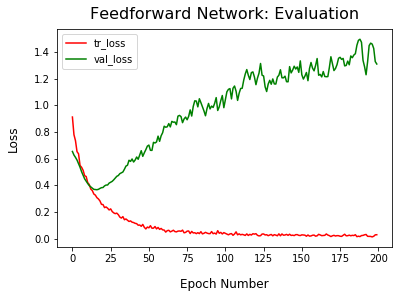

------------------------------------------------------------------------------------------------------------------------------ 




Evaluation Metrics for Critical Reviews: 

                     Classifier  F1-Score  Recall  Precision  Evalutation Time
0  Feedforward_Network_Baseline     0.608    0.69      0.544            48.859


In [200]:
# training and evaluation
dl_clf_ff_algo(X_train, X_test, y_train, o_y_test)

### Machine Learning

#### Class Balancing, Embeddings

In [201]:
# preprocessing
X_train = np.array([sent2vec(x, stop_list) for x in (o_X_train)])
X_test = np.array([sent2vec(x, stop_list) for x in (o_X_test)])
y_train = o_y_train

In [202]:
# training and evaluation
ml_clf_li_algo(X_train, X_test, y_train, o_y_test)


Evaluation Metrics for Critical Reviews: 

                     Classifier  F1-Score  Recall  Precision  Evalutation Time
0          Naive_Bayes_Baseline     0.000   0.000      0.000             0.012
1  Logistic_Regression_Baseline     0.629   0.819      0.511             0.164
2           Linear_SVC_Baseline     0.635   0.802      0.525             1.045
3                  SVC_Baseline     0.692   0.853      0.582             3.879
4        Random_Forest_Baseline     0.232   0.138      0.727             2.804
5    Gradient_Boosting_Baseline     0.564   0.457      0.736             3.805


### Machine Learning

#### Grid Search with Class Weights, TfIdf

In [203]:
# grid search for machine learning
def gridsearch_pipeline(xtr, xte, ytr, yte):
    
    # defining class weights
    pop_weights = dict(enumerate(compute_class_weight('balanced', np.unique(ytr), 
                                                     ytr)))
    
    clf_names = ["Logistic_Regression_GrSrch",
                 "Linear_SVC_GrSrch", "SVC_GrSrch"]

    classifiers = [LogisticRegression(class_weight=pop_weights),
                   LinearSVC(class_weight=pop_weights), 
                   SVC(class_weight=pop_weights)]
    
    svd_obj = TruncatedSVD()
    svd_component_list=np.linspace(100, 250, num=4, endpoint=True).astype(int)
    
    # defining parameters for pipeline
    parameters = [
                  {'svd__n_components': svd_component_list,
                   'clf__penalty': ('l1', 'l2'),
                   'clf__C': [0.01, 0.1, 1],
                   'clf__solver': ('liblinear', 'saga')},
                  {'svd__n_components': svd_component_list,
                   'clf__penalty': ('l1', 'l2'),
                   'clf__loss': ('hinge', 'squared_hinge'),
                   'clf__C': [0.01, 0.1, 1]},
                  {'svd__n_components': svd_component_list,
                   'clf__C': [0.01, 0.1, 1],
                   'clf__kernel': ('poly', 'rbf', 'sigmoid'),
                   'clf__gamma': ('scale', 'auto')}
                    ]
    
    f1_list = []
    precision_list = []
    recall_list = []
    time_list = []
    
    conf_list = []
    
    # defining custom scorers
    custom_scoring = {'F1-Score-Minority': make_scorer(f1_filter),
                      'Recall-Score-Minority': make_scorer(recall_filter), 
                      'Precision-Score-Minority': make_scorer(precision_filter)}
    
    # grid search for each classifier and cross validationa cross 5 folds
    for name, classifier, params in tqdm(zip(clf_names, classifiers, parameters)):
        clf_pipe = Pipeline([('svd', svd_obj),
            ('scl', StandardScaler()),
            ('clf', classifier)])
        t0 = time.time()
        gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring = custom_scoring, 
                              refit='F1-Score-Minority', 
                              n_jobs=-1, cv=5, verbose=1)
        clf = gs_clf.fit(X_train, y_train)
        f1_list.append(round(f1_filter(yte, clf.predict(xte)),3))
        recall_list.append(round(recall_filter(yte, clf.predict(xte)),3))
        precision_list.append(round(precision_filter(yte, clf.predict(xte)),3))
        t1 = time.time()
        time_list.append(round(t1-t0,3))
        
        conf_list.append(confusion_matrix(yte, clf.predict(xte))) 
    
    # storing evaulation metrics
    metrics_df = pd.DataFrame.from_dict({'Classifier': clf_names, 
                                         'F1-Score': f1_list,
                                         'Recall': recall_list,
                                         'Precision': precision_list,
                                         'Evalutation Time': time_list})
    
    print("Evaluation Metrics for Critical Reviews:", "\n")
    print(metrics_df, "\n\n","-"*126) 
    
    # defining confusion matrix
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                              cmap=plt.cm.Blues):

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=16)
        plt.colorbar(shrink=0.3)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes, rotation=90)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label', fontsize=12)
        plt.xlabel('Predicted label', fontsize=12)
        
    labels=["Negative","Non Negative"]
        
    fig = plt.figure(figsize=(16,8))
    
    for i in range(len(clf_names)):
        fig.add_subplot(1,3,i+1)
        plot_confusion_matrix(conf_list[i], labels, title=clf_names[i], cmap=plt.cm.Greens)

In [204]:
# preprocessing
X_train, X_test = w2numbers(o_X_train, o_X_test)
y_train = o_y_train

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 13.1min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 12.6min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 24.7min finished



Evaluation Metrics for Critical Reviews: 

                   Classifier  F1-Score  Recall  Precision  Evalutation Time
0  Logistic_Regression_GrSrch     0.644   0.828      0.527           791.237
1           Linear_SVC_GrSrch     0.664   0.802      0.567           764.076
2                  SVC_GrSrch     0.643   0.793      0.541          1495.171 

 ------------------------------------------------------------------------------------------------------------------------------


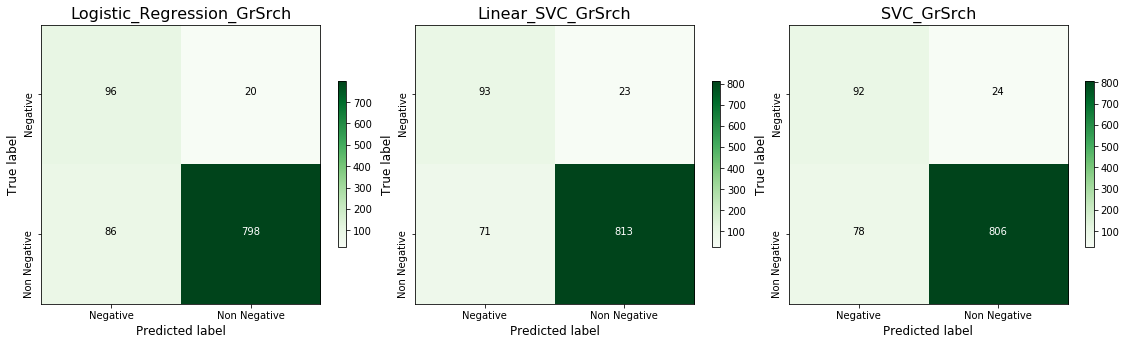

In [205]:
# training and evaluation
gridsearch_pipeline(X_train, X_test, y_train, o_y_test)